In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd

In [2]:
#loading the data
pd.read_csv('data/train.csv').head()


FileNotFoundError: File b'data/train.csv' does not exist

In [3]:
from torchtext.data import Field

tokenize = lambda x: x.split()
#lowercased, whitespace-tokenized, and preprocessed
TEXT = Field(sequential=True, tokenize=tokenize, lower=True)
#labels is numeric already
LABEL = Field(sequential=False, use_vocab=False)

In [4]:
from torchtext.data import TabularDataset
trvld_datafields = [("id", None),
                ("comment_text", TEXT), ("toxic", LABEL),
                ("severe_toxic", LABEL), ("threat", LABEL),
                ("obscene", LABEL), ("insult", LABEL),
                ("identity_hate", LABEL)]

trn, vld = TabularDataset.splits(
            path="data",
            train="train.csv", validation="valid.csv",
            format="csv", skip_header=True,
            fields=trvld_datafields)

tst_datafields = [("id", None), ("comment_text", TEXT)]
tst = TabularDataset(
        path="data/test.csv", format="csv", skip_header=True, fields=tst_datafields)

print ('size of the train, dev, test dataset:', len(trn), len(vld), len(tst))
# print (trn.fields.items())
print (trn[0].comment_text)
#print (tst[0].comment_text) 


size of the train, dev, test dataset: 25 25 33
['explanation', 'why', 'the', 'edits', 'made', 'under', 'my', 'username', 'hardcore', 'metallica', 'fan', 'were', 'reverted?', 'they', "weren't", 'vandalisms,', 'just', 'closure', 'on', 'some', 'gas', 'after', 'i', 'voted', 'at', 'new', 'york', 'dolls', 'fac.', 'and', 'please', "don't", 'remove', 'the', 'template', 'from', 'the', 'talk', 'page', 'since', "i'm", 'retired', 'now.89.205.38.27']


In [5]:
from torchtext import vocab
vec = vocab.Vectors('data/glove.6B.50d.txt', './data/')
TEXT.build_vocab(trn, vld, max_size=200, vectors=vec)
print ('size of the vocab and embedding dim:', TEXT.vocab.vectors.shape) #size=202,50 (max vocab size=200+2 for <unk> and <pad>, and glove vector dim=50)
print ('index of the in the vocab:', TEXT.vocab.stoi['the']) #output:2, so the index 2 in vocab is for 'the'
print ('index 0 in the vocab:', TEXT.vocab.itos[0]) #output:<unk>, so the index 0 in vocab is for '<unk>'
#print ('embedding vector for 'the':', TEXT.vocab.vectors[TEXT.vocab.stoi['the']])

#print (TEXT.vocab.freqs.most_common(10))
#print (trn[0].__dict__.keys())
#print (trn[0].comment_text[:5])

size of the vocab and embedding dim: torch.Size([202, 50])
index of the in the vocab: 2
index 0 in the vocab: <unk>


In [6]:
#BucketIterator groups sequence of similar lengths text in a batch together to minimize padding! how cool is that!
from torchtext.data import Iterator, BucketIterator
train_iter, val_iter = BucketIterator.splits((trn, vld),
                                            batch_sizes=(3,3),
                                            device='cuda',
                                            sort_key=lambda x: len(x.comment_text), #tell the bucketIterator how to group the sequences
                                            sort_within_batch=False,
                                            repeat=False) #we want to wrap this Iterator layer
test_iter = Iterator(tst, batch_size=3, device='cuda', sort=False, sort_within_batch=False, repeat=False)

print ('number of batch (size: 3):', len(train_iter), len(val_iter)) #output: 9,9. because our train and val data only has 25 examples. since the batch size is 3, it means we have 25/3: 9 batches for each train and val

batch = next(iter(train_iter))
print ('details of batch:', batch)
print ("the content of 'toxic' for the first 3 examples in batch 1:", batch.toxic)
#print ("the content of 'comment_text' for the first 3 examples in batch 1, size depends on the longest sequence:", batch.comment_text)
#print (batch.dataset.fields)

number of batch (size: 3): 9 9
details of batch: 
[torchtext.data.batch.Batch of size 3]
	[.comment_text]:[torch.cuda.LongTensor of size 81x3 (GPU 0)]
	[.toxic]:[torch.cuda.LongTensor of size 3 (GPU 0)]
	[.severe_toxic]:[torch.cuda.LongTensor of size 3 (GPU 0)]
	[.threat]:[torch.cuda.LongTensor of size 3 (GPU 0)]
	[.obscene]:[torch.cuda.LongTensor of size 3 (GPU 0)]
	[.insult]:[torch.cuda.LongTensor of size 3 (GPU 0)]
	[.identity_hate]:[torch.cuda.LongTensor of size 3 (GPU 0)]
the content of 'toxic' for the first 3 examples in batch 1: tensor([0, 0, 0], device='cuda:0')


In [7]:
class BatchGenerator:
    def __init__(self, dl, x, y):
        self.dl, self.x, self.y = dl, x, y
    def __len__(self):
        return len(self.dl)
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x) #assuming one input
            if self.y is not None: #concat the y into single tensor
                y = torch.cat([getattr(batch, feat).unsqueeze(1) for feat in self.y], dim=1).float()
            else:
                y = torch.zeros((1))
            yield (X,y)

train_batch_it = BatchGenerator(train_iter, 'comment_text', ['toxic', 'threat'])
#print ('get data x and y out of batch object:', next(iter(train_batch_it)))
valid_batch_it = BatchGenerator(val_iter, 'comment_text', ['toxic', 'threat'])
test_batch_it = BatchGenerator(test_iter, 'comment_text', None)
#print (next(test_batch_it.__iter__()))

In [8]:
import torch.optim as optim
import torch.nn as nn
from model import BiLSTM

vocab_size = len(TEXT.vocab)
emb_dim = 50
hidden_dim = 50
out_dim = 2 #only use 'toxic' and 'threat'
pretrained_vec = trn.fields['comment_text'].vocab.vectors
model = BiLSTM(vocab_size, hidden_dim, emb_dim, out_dim, pretrained_vec)
print (model)
model.cuda()

BiLSTM(
  (embedding): Embedding(202, 50)
  (encoder): LSTM(50, 50, num_layers=2, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=100, out_features=50, bias=True)
  (predictor): Linear(in_features=50, out_features=2, bias=True)
)


BiLSTM(
  (embedding): Embedding(202, 50)
  (encoder): LSTM(50, 50, num_layers=2, dropout=0.1, bidirectional=True)
  (linear): Linear(in_features=100, out_features=50, bias=True)
  (predictor): Linear(in_features=50, out_features=2, bias=True)
)

In [9]:
import tqdm
import torch
import numpy as np
opt = optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.BCEWithLogitsLoss()
epochs = 100
train_loss = []
valid_loss = []

for epoch in range(1, epochs+1):
    training_loss = 0.0
    training_corrects = 0
    model.train()
    for x, y in tqdm.tqdm(train_batch_it):
        opt.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)

        loss.backward()
        opt.step()
        training_loss += loss.item() * x.size(0)
    epoch_loss = training_loss/ len(trn)

    val_loss = 0.0
    model.eval()
    for x,y in valid_batch_it:
        preds = model(x)
        loss = criterion(preds, y)
        val_loss += loss.item() * x.size(0)
    val_loss /= len(vld)
    train_loss.append(epoch_loss)
    valid_loss.append(val_loss)
    print ('Epoch: {}, Training loss: {:.4f}, Validation loss: {:.4f}'.format(epoch, epoch_loss, val_loss))
    
#predictions. note that the preds is the probability of the comment belong in each category output
test_preds = []
for x, y in tqdm.tqdm(test_batch_it):
    preds = model(x)
    preds = preds.data.cpu().numpy()
    preds = 1/(1+np.exp(-preds)) #actual output of the model are logits, so we need to pass into sigmoid function
    test_preds.append(preds)
    print (y, ' >>> ',  preds)

test_preds = np.hstack(test_preds)


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1, Training loss: 25.9261, Validation loss: 8.6712
Epoch: 2, Training loss: 8.9861, Validation loss: 7.9194


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 3, Training loss: 5.4544, Validation loss: 8.8107
Epoch: 4, Training loss: 11.9140, Validation loss: 7.6765


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 5, Training loss: 10.6329, Validation loss: 8.3382
Epoch: 6, Training loss: 12.8446, Validation loss: 10.4829


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 7, Training loss: 8.2467, Validation loss: 8.2900
Epoch: 8, Training loss: 8.8832, Validation loss: 7.9705


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 9, Training loss: 11.8716, Validation loss: 7.6113
Epoch: 10, Training loss: 12.1771, Validation loss: 7.2746


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 11, Training loss: 8.7196, Validation loss: 7.6162
Epoch: 12, Training loss: 9.1371, Validation loss: 8.1272


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 13, Training loss: 6.4291, Validation loss: 7.6623
Epoch: 14, Training loss: 10.9454, Validation loss: 7.3563


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 15, Training loss: 10.5560, Validation loss: 6.9568
Epoch: 16, Training loss: 7.8639, Validation loss: 6.8757


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 17, Training loss: 6.6210, Validation loss: 7.2120
Epoch: 18, Training loss: 5.3851, Validation loss: 7.4727


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 19, Training loss: 9.1602, Validation loss: 6.5013
Epoch: 20, Training loss: 7.9533, Validation loss: 6.6524


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 21, Training loss: 9.7760, Validation loss: 6.8804
Epoch: 22, Training loss: 13.1008, Validation loss: 8.4852


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 23, Training loss: 15.8049, Validation loss: 9.9014
Epoch: 24, Training loss: 15.0032, Validation loss: 10.3156


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 25, Training loss: 9.6093, Validation loss: 7.3690
Epoch: 26, Training loss: 5.7690, Validation loss: 7.4250


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 27, Training loss: 7.5847, Validation loss: 6.7760
Epoch: 28, Training loss: 5.0818, Validation loss: 7.2657


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 29, Training loss: 4.1081, Validation loss: 7.4917
Epoch: 30, Training loss: 14.2057, Validation loss: 6.7578


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 31, Training loss: 7.1429, Validation loss: 7.2330
Epoch: 32, Training loss: 6.5178, Validation loss: 7.2265


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 33, Training loss: 4.4982, Validation loss: 9.9698
Epoch: 34, Training loss: 5.7007, Validation loss: 16.3991


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 35, Training loss: 3.9495, Validation loss: 12.0924
Epoch: 36, Training loss: 5.8923, Validation loss: 13.5782


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 37, Training loss: 2.0049, Validation loss: 14.0174
Epoch: 38, Training loss: 2.3065, Validation loss: 13.7082


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 39, Training loss: 4.9104, Validation loss: 15.1372
Epoch: 40, Training loss: 3.9242, Validation loss: 15.6447


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 41, Training loss: 1.5951, Validation loss: 18.3174
Epoch: 42, Training loss: 0.7603, Validation loss: 19.5606


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 43, Training loss: 2.8748, Validation loss: 20.1505
Epoch: 44, Training loss: 1.2025, Validation loss: 20.9457


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 45, Training loss: 1.2457, Validation loss: 21.3389
Epoch: 46, Training loss: 0.6532, Validation loss: 22.1204


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 47, Training loss: 1.5290, Validation loss: 22.8157
Epoch: 48, Training loss: 0.3231, Validation loss: 22.9344


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 49, Training loss: 5.2015, Validation loss: 22.5624
Epoch: 50, Training loss: 1.1844, Validation loss: 22.1335


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 51, Training loss: 4.0053, Validation loss: 22.4229
Epoch: 52, Training loss: 1.3590, Validation loss: 22.4594


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 53, Training loss: 2.6327, Validation loss: 22.0849
Epoch: 54, Training loss: 1.3539, Validation loss: 22.3474


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 55, Training loss: 4.3041, Validation loss: 25.4092
Epoch: 56, Training loss: 5.3848, Validation loss: 15.5486


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 57, Training loss: 10.3114, Validation loss: 15.1265
Epoch: 58, Training loss: 6.1756, Validation loss: 15.0428


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 59, Training loss: 2.5975, Validation loss: 10.9940
Epoch: 60, Training loss: 2.1628, Validation loss: 8.2607


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 61, Training loss: 105.2827, Validation loss: 16.2615
Epoch: 62, Training loss: 14.9346, Validation loss: 12.9086


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 63, Training loss: 15.4586, Validation loss: 7.1040
Epoch: 64, Training loss: 9.5348, Validation loss: 8.4938


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 65, Training loss: 5.5719, Validation loss: 15.6646
Epoch: 66, Training loss: 5.9162, Validation loss: 7.5035


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 67, Training loss: 17.1358, Validation loss: 7.4945
Epoch: 68, Training loss: 6.1251, Validation loss: 7.7615


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 69, Training loss: 8.5145, Validation loss: 7.0017
Epoch: 70, Training loss: 9.2276, Validation loss: 7.0544


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 71, Training loss: 10.5273, Validation loss: 7.2567
Epoch: 72, Training loss: 20.5243, Validation loss: 7.3064


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 73, Training loss: 6.6637, Validation loss: 7.8810
Epoch: 74, Training loss: 15.1321, Validation loss: 7.6079


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 75, Training loss: 8.8468, Validation loss: 6.5537
Epoch: 76, Training loss: 12.7855, Validation loss: 6.7395


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 77, Training loss: 14.4861, Validation loss: 7.1297
Epoch: 78, Training loss: 8.6720, Validation loss: 7.3325


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 79, Training loss: 8.3913, Validation loss: 6.6825
Epoch: 80, Training loss: 12.7401, Validation loss: 6.7922


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 81, Training loss: 6.3481, Validation loss: 6.6650
Epoch: 82, Training loss: 8.8273, Validation loss: 6.6328


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 83, Training loss: 20.3149, Validation loss: 7.1748
Epoch: 84, Training loss: 4.7511, Validation loss: 8.0911


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 85, Training loss: 5.0704, Validation loss: 6.5089
Epoch: 86, Training loss: 9.4381, Validation loss: 7.0468


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 87, Training loss: 8.8277, Validation loss: 6.9935
Epoch: 88, Training loss: 5.5958, Validation loss: 7.2249


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 89, Training loss: 20.3986, Validation loss: 6.9715
Epoch: 90, Training loss: 7.6194, Validation loss: 7.1846


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 91, Training loss: 19.9324, Validation loss: 7.4958
Epoch: 92, Training loss: 6.3905, Validation loss: 7.4822


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 93, Training loss: 4.7218, Validation loss: 7.4334
Epoch: 94, Training loss: 5.0313, Validation loss: 8.1144


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 95, Training loss: 6.0118, Validation loss: 8.5890
Epoch: 96, Training loss: 6.1063, Validation loss: 7.4158


  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 97, Training loss: 6.5337, Validation loss: 7.3633
Epoch: 98, Training loss: 10.6001, Validation loss: 11.2602


100%|██████████| 11/11 [00:00<00:00, 327.67it/s]


Epoch: 99, Training loss: 8.1684, Validation loss: 6.8993
Epoch: 100, Training loss: 9.4210, Validation loss: 7.2161
tensor([0.])  >>>  [[0.23881277 0.08824946]
 [0.2781726  0.11172245]
 [0.28724715 0.11747126]]
tensor([0.])  >>>  [[0.27978233 0.11262092]
 [0.10079432 0.02104778]
 [0.26009873 0.10076674]]
tensor([0.])  >>>  [[0.10489148 0.02876967]
 [0.24622346 0.09321608]
 [0.29209104 0.12114687]]
tensor([0.])  >>>  [[2.6763532e-01 1.0560413e-01]
 [1.2381314e-03 1.2568892e-05]
 [3.1831092e-01 1.3874455e-01]]
tensor([0.])  >>>  [[0.17121172 0.05217163]
 [0.289176   0.11895587]
 [0.2665556  0.10475722]]
tensor([0.])  >>>  [[0.27845877 0.11231128]
 [0.33459753 0.15155105]
 [0.08024506 0.0183387 ]]
tensor([0.])  >>>  [[0.30856246 0.13241799]
 [0.247048   0.09342492]
 [0.3295039  0.14782819]]
tensor([0.])  >>>  [[2.7767038e-01 1.1168647e-01]
 [2.5713423e-01 9.9487007e-02]
 [1.2169953e-03 1.2569467e-05]]
tensor([0.])  >>>  [[0.08982021 0.02342796]
 [0.24915685 0.09479842]
 [0.26266423 0.102

range(1, 101)


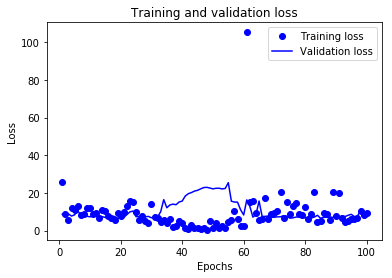

In [12]:
import matplotlib.pyplot as plt

ep = range(1, epochs+1)
print (ep)
plt.plot(ep, train_loss, 'bo', label='Training loss')
plt.plot(ep, valid_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# plt.savefig('plt.png')
#print (test_preds)


In [11]:
import sys
sys.exit()

#write predictions to csv
df = pd.read_csv("data/test.csv") 
for i, col in enumerate(["toxic", "threat"]):
    df[col] = test_preds[:, i]
df.head()
       

SystemExit: 

/home/jerry/workshop/virtualenv/alpha-mind/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3275: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
